In [ ]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd



In [ ]:
# 从 Excel 文件读取数据
df = pd.read_excel('data.xlsx')

# 提取列数据
u1_data = df['u1'].values
u2_data = df['u2'].values
y1_data = df['y1'].values
y2_data = df['y2'].values

# # 输出提取的数据
# print('u1_data:', u1_data.shape)
# print('u2_data:', u2_data.shape)
# print('y1_data:', y1_data.shape)
# print('y2_data:', y1_data.shape)

num_samples = y1_data.shape[0]


In [34]:
# 组合训练数据  多输入双输出
# 假设有训练数据 u1_data, u2_data, y1_data 和 y1_data+1
# 将它们组合成输入特征矩阵 X 和输出标签向量 y
# 1 |2| 3 4 5 6 
# 6 |1| 2 3 4 5
# 1 |2| 3 4 5 6 

u1_data = u1_data
u2_data = u2_data

u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0

y1_data = y1_data
y2_data = y2_data

X = np.column_stack((   u1_data  [1:-1], u2_data  [1:-1],
                        u1_data_1[1:-1], u2_data_1[1:-1],
                        y1_data  [1:-1], y2_data  [1:-1])
                    )
y = np.column_stack((y1_data[2:],y2_data[2:]))

print(X.shape,y.shape)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333333, random_state=42)


In [ ]:
# 获取模型参数
def get_params(W_b):

    mid_indix = W_b.shape[0]//2-1
    pred_0 = W_b[-2:-1]
    W0 = W_b[:mid_indix]
    b1 = W_b[-1:]
    W1 = W_b[mid_indix:mid_indix*2]
    W_b_0 = np.concatenate((W0, pred_0))
    W_b_1 = np.concatenate((W1, b1))
    # print(mid_indix)

    # print('pred_0:',pred_0.shape)
    # print('W0:',W0.shape)
    # print('b1:',b1.shape)
    # print('W1:',W1.shape)
    return pred_0,W0,b1,W1,W_b_0,W_b_1


In [ ]:
# 定义My_LS_SVRModel
class My_M_LS_SVRModel:
    def __init__(self, params):
        C0, C1, C00, gamma= params
        self.C0 = C0
        self.C1 = C1
        self.C00 = C00
        self.gamma = gamma
        self.W_b = None
        self.X_train = None

    def model_train(self, X_train, y_train, K_train):
        def objective(W_b, X, y):
            b0,W0,b1,W1,W_b_0,W_b_1 = get_params(W_b)

            y_pred_0 = np.dot(K_train, W0) + b0
            y_pred_1 = np.dot(K_train, W1) + b1
            errors0 = y[:,0] - y_pred_0
            errors1 = y[:,1] - y_pred_1

            # 损失函数
            loss = ( 0.5 * (np.dot(W0, W0)+np.dot(W1, W1)) 
                    + self.C0 * np.sum(errors0**2) + self.C1 * np.sum(errors1**2)
                    # + C00 * np.sum(np.sqrt(errors0**2 + errors1**2)) # L2 范数
                    + self.C00 * np.sum(errors0**2 + errors1**2) # L2 范数的平方
                    )
            return loss

        # 初始化权重向量+偏移项b
        initial_W_b = np.zeros((X_train.shape[0])*2+(1)*2)

        # 使用minimize 函数最小化目标函数
        result = minimize(objective, initial_W_b, args=(X_train, y_train),
                            method='L-BFGS-B')
        # 输出最优的权重向量
        best_W_b = result.x
        return best_W_b

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = rbf_kernel(X_train, X_train, gamma=self.gamma)
        self.W_b = self.model_train(X_train, y_train, K_train)

    def predict(self, X_test):
        b0,W0,b1,W1,W_b_0,W_b_1 = get_params(self.W_b)
        K_test = rbf_kernel(X_test, self.X_train, gamma=self.gamma)
        y_pred_0 = np.dot(K_test, W0) + b0
        y_pred_1 = np.dot(K_test, W1) + b1
        return y_pred_0, y_pred_1
    

# # 示例用法
# params = [8.78525340e+01, 2.01347249e-03]
# # 创建模型
# my_svr_model = My_LS_SVRModel(params=params)
# # 训练模型
# my_svr_model.fit(X_train, y_train)
# # 模型预测
# y_pred = my_svr_model.predict(X_test)


In [ ]:
# 粒子群参数设置
Particle_num = 10
iterations_max=30


iteration 0
i 0 mse 1.4124358526710419 position [19.09934838 19.31256969 83.2407965  45.22877915]
i 1 mse 1.4025247690585312 position [ 8.10739131 21.36489446 95.02188821 73.84384943]
i 2 mse 1.426595825036552 position [74.18520218 40.13383063 37.95658781 56.66029914]
i 3 mse 1.5179028820726386 position [78.43077599 31.36797213 19.4271359  22.93182914]
i 4 mse 1.2799481116011826 position [39.77007162 62.61005371  9.04740248  8.94894813]
i 5 mse 1.4027445155761162 position [64.37247907 81.76797269 70.95382906 92.44969056]
i 6 mse 1.4489785190686446 position [27.79350604  8.35499916 56.42119748 41.95972771]
i 7 mse 1.4027908581693505 position [61.63445765 24.38775104 68.30834278 94.62058719]
i 8 mse 0.8989484017134434 position [36.63677794 39.12344299 73.27596959  2.71634346]
i 9 mse 1.4473676290335422 position [76.96795349 46.51051119 58.04321534 52.76323101]
[36.63677794 39.12344299 73.27596959  2.71634346] 0.8989484017134434
iteration 1
i 0 mse 1.4124063161403697 position [20.09934838

<Figure size 1000x600 with 0 Axes>

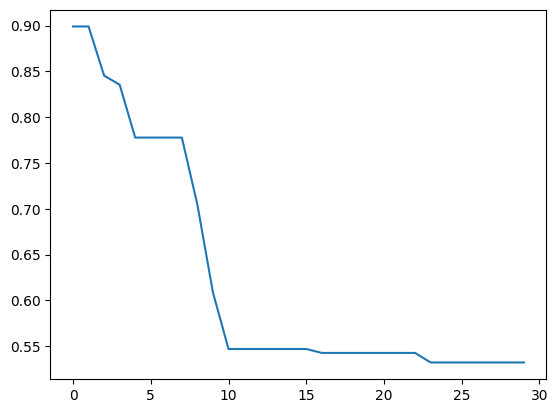

<Figure size 1000x600 with 0 Axes>

In [25]:
# 粒子群优化
def initialize_particles(Particle_num, params_num, Xmin, Xmax, Vmin, Vmax):
    # 初始化粒子群的位置和速度
    positions = np.random.uniform(Xmin, Xmax, size=(Particle_num, params_num))
    # plt.plot(positions[:,0],positions[:,1])
    velocities = np.random.uniform(Vmin, Vmax, size=(Particle_num, params_num))
    return positions, velocities
def evaluate_fitness(positions, fitness_values, X_train, y_train, X_test, y_test):
    # 在这里计算适应值（均方根误差）
    fitness_values = your_fitness_function(positions, fitness_values, X_train, y_train, X_test, y_test)
    return fitness_values
def update_personal_best(personal_best_positions, personal_best_fitness, positions, fitness_values):
    # 对每个粒子进行循环
    for i in range(len(positions)):
        # 如果当前适应值更好，则更新个体最佳位置和适应值
        if fitness_values[i] < personal_best_fitness[i]:
            personal_best_positions[i] = positions[i].copy()
            personal_best_fitness[i] = fitness_values[i]
    return personal_best_positions, personal_best_fitness
def update_global_best(global_best_position, global_best_fitness, personal_best_positions, personal_best_fitness):
    # 找到所有粒子中适应值最好的粒子的索引
    best_particle_index = np.argmin(personal_best_fitness)
    # 如果该粒子的适应值更好，则更新全局最佳位置和适应值
    if personal_best_fitness[best_particle_index] < global_best_fitness:
        global_best_position[:] = personal_best_positions[best_particle_index].copy()
        global_best_fitness = personal_best_fitness[best_particle_index]
    return global_best_position,global_best_fitness
def update_particles(iteration, iterations_max, positions, velocities, personal_best_positions, global_best_position, 
                    c1, c2, Xmin, Xmax, Vmin, Vmax):
    # 更新粒子的速度和位置
    r1 = np.random.rand(*positions.shape)
    r2 = np.random.rand(*positions.shape)
    
    w_max = 0.9
    w_min = 0.4
    weight = w_max - iteration*(w_max-w_min)/iterations_max
    # weight = 1
    velocities = weight * velocities + c1 * r1 * (personal_best_positions - positions) + c2 * r2 * (global_best_position - positions)
    # 限制速度范围
    velocities = np.clip(velocities, Vmin, Vmax)
    # 更新位置
    positions = positions + velocities
    # 限制位置范围
    positions = np.clip(positions, Xmin, Xmax)

    return positions, velocities
def pso_algorithm(Particle_num, Xmin, Xmax, Vmin, Vmax, iterations_max, params_num, C1, C2, tao, X_train, y_train, X_test, y_test):
    # 初始化粒子群
    positions, velocities = initialize_particles(Particle_num, params_num, Xmin, Xmax, Vmin, Vmax)

    # 初始化每个粒子的个体最佳位置和适应值
    personal_best_positions = positions.copy()
    personal_best_fitness = np.full(Particle_num, np.inf)#所有元素的值都设置为正无穷
    
    # 初始化全局最佳位置和适应值
    global_best_position = np.zeros(params_num)
    global_best_fitness = np.inf

    fitness_values = np.zeros(Particle_num)
    # 开始迭代
    fitness_values_list = []  # 用于存储每次迭代后的最佳适应值
    for iteration in range(iterations_max):
        print('iteration',iteration)
        # 计算每个粒子的适应值
        fitness_values = evaluate_fitness(positions, fitness_values, X_train, y_train, X_test, y_test)
        
        # 更新个体最佳位置和适应值
        personal_best_positions, personal_best_fitness = update_personal_best(personal_best_positions, personal_best_fitness, positions, fitness_values)
        
        # 更新全局最佳位置和适应值
        global_best_position,global_best_fitness = update_global_best(global_best_position, global_best_fitness, personal_best_positions, personal_best_fitness)
        print(global_best_position,global_best_fitness)
        # 更新粒子的速度和位置
        positions, velocities = update_particles(iteration, iterations_max,positions, velocities, personal_best_positions, global_best_position, C1, C2, Xmin, Xmax, Vmin, Vmax)
        
        # 记录适应度值
        fitness_values_list.append(global_best_fitness)
        
        # 检查收敛精度
        if global_best_fitness < tao:
            break

    # 返回最终的全局最佳位置和适应值
    return global_best_position, global_best_fitness, fitness_values_list
# 替换为你实际的目标函数
def your_fitness_function(positions, fitness_values, X_train, y_train, X_test, y_test):
    for i in range(len(positions)):
        # 示例用法
        params = positions[i]
        # 创建模型
        my_svr_model = My_M_LS_SVRModel(params=params)
        # 训练模型
        my_svr_model.fit(X_train, y_train)
        # 模型预测
        y_pred_0, y_pred_1 = my_svr_model.predict(X_test)        
        # 在这里计算适应值（均方根误差）
        errors0 = y_test[:,0] - y_pred_0
        errors1 = y_test[:,1] - y_pred_1
        mse = np.sqrt(np.sum(errors0**2+errors1**2)/X_test.shape[0])
        fitness_values[i] = mse

        print('i',i,"mse",mse,"position",params)
    return fitness_values



# position = [C0, C1, C00, gamma]
# 调用粒子群算法
vel = 1
Xmin = [0]
Xmax = [100]
result_position, result_fitness, fitness_values_list = pso_algorithm(Particle_num = Particle_num, Xmin=Xmin, Xmax=Xmax, Vmin=-vel, Vmax=vel, 
                                                iterations_max = iterations_max, params_num = 4, C1=2, C2=2, tao=0.1, 
                                                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# 输出结果
print(f"Global Best Position and Fitness: {result_position}  {result_fitness}")

plt.plot(fitness_values_list)
plt.figure(figsize=(10, 6))  


In [1]:
# 创建模型
#  data  [23.65353603, 46.24063272, 14.1795326,   0.14215454]  0.29159782217670577
#  data2  [36.82522053 53.21374946 18.48987828  0.15809682]  0.5322094851234387
#  [11.16 ,10.23 ,9.64,  0.09] 
params =   [11.16 ,10.23 ,9.64,  0.09] 
my_svr_model = My_M_LS_SVRModel(params=params)
# 训练模型
my_svr_model.fit(X_train, y_train)
# 模型预测
y_pred_0, y_pred_1 = my_svr_model.predict(X_test)


NameError: name 'My_M_LS_SVRModel' is not defined

In [36]:
# 计算 RMSE
y_test = y_test
rmse_0 = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_0))
rmse_1 = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_1))

# 计算 MRE
mre_0 = np.mean(np.abs((y_test[:, 0] - y_pred_0) / y_test[:, 0])) * 100
mre_1 = np.mean(np.abs((y_test[:, 1] - y_pred_1) / y_test[:, 1])) * 100

# 打印结果
print("Dimension 0:")
print("RMSE:", rmse_0)
print("MRE:", mre_0)

print("\nDimension 1:")
print("RMSE:", rmse_1)
print("MRE:", mre_1)


Dimension 0:
RMSE: 0.3759807718671248
MRE: 713.7417497150393

Dimension 1:
RMSE: 0.37667686699243136
MRE: 245.95941539842318


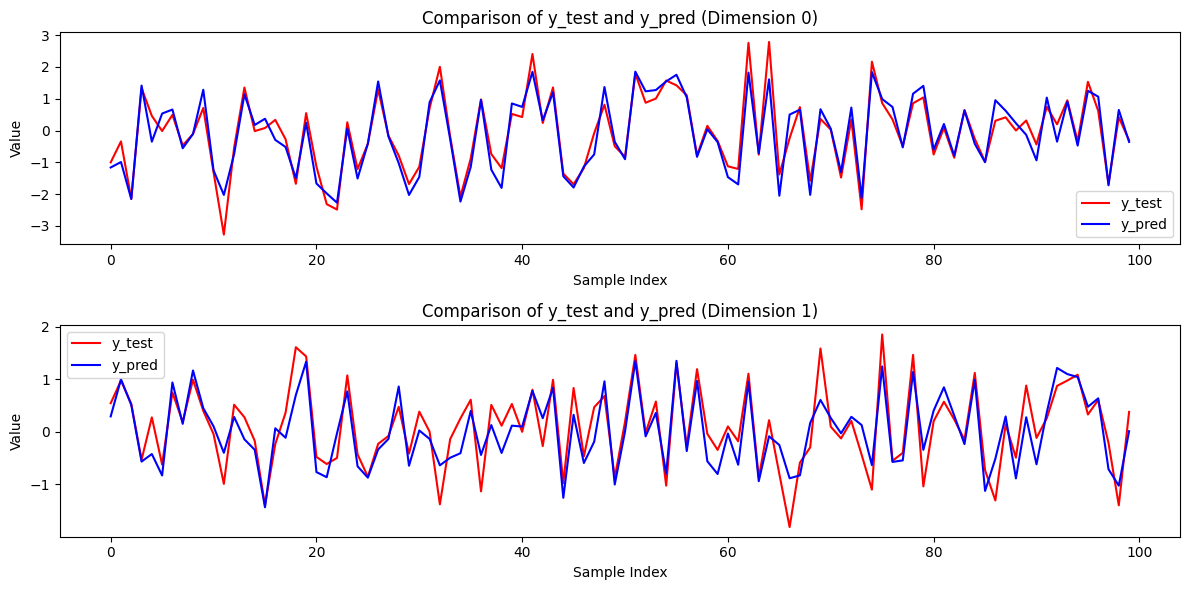

In [37]:
# 模型预测结果
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(12, 6))

# 第一个维度的曲线
plt.subplot(2, 1, 1)
plt.plot(y_test[:, 0], 'r-', label='y_test')
plt.plot(y_pred_0, 'b-', label='y_pred')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of y_test and y_pred (Dimension 0)')
plt.legend()

# 第二个维度的曲线
plt.subplot(2, 1, 2)
plt.plot(y_test[:, 1], 'r-', label='y_test')
plt.plot(y_pred_1, 'b-', label='y_pred')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of y_test and y_pred (Dimension 1)')
plt.legend()

# 调整子图布局
plt.tight_layout()
plt.show()


In [ ]:
# 生成参考轨迹
def get_yr(aim_value,current_value,alpha,P):
    # 生成设定信号
    setpoint_signal = np.full(10, aim_value)
    # 初始化参数
    alpha = alpha
    y_r = np.zeros(P)
    y_r[0] = current_value
    # 模拟一阶模型
    for k in range(1,P):
        y_r[k] = alpha * y_r[k-1] + (1 - alpha) * aim_value

    # # 绘制结果
    # plt.plot(setpoint_signal, label='Setpoint Signal')
    # plt.plot(y_r,'o-', label='Output Signal (Tracked)')
    # plt.legend()
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Tracking Setpoint Signal with One-Order Model')
    # plt.show()
    return y_r
# 测试
# y_r = get_yr(1,-0.5,0.333,5+1)


In [ ]:
# 生成期望数据
Times = 200

def generate_y_aim_data(Times):
    set_y1 = np.full(Times, 0.5)
    set_y1[30:51] = 0.6
    set_y1[80:101] = 0.7
    set_y1[130:151] = 0.0
    set_y1[170:201] = 0.4
    set_y1[185] = -0.7  # 添加脉冲干扰

    set_y2 = np.full(Times, 0.3)
    set_y2[50:81] = -0.1
    set_y2[100:131] = 0.5
    set_y2[150:171] = -0.7  # 添加脉冲干扰
    set_y2[200:] = 0.4

    # 限制设定值在 -1 到 1 之间
    set_y1 = np.clip(set_y1, -1, 1)
    set_y2 = np.clip(set_y2, -1, 1)

    return set_y1, set_y2



# 调用示例
set_y1, set_y2 = generate_y_aim_data(Times)
plt.plot(set_y1)
plt.plot(set_y2)



In [ ]:
# 生成控制时域的数据格式
def generate_k_data(u1_data, u2_data, y1_data, num_samples, P):
    # 生成随机索引值
    #从原有数据的randint时刻开始往下进行控制
    randint = np.random.randint(1, num_samples - 2 - P - 1)
    # randint = 13  # 如果你希望使用固定的值而不是随机生成

    # 提取数据并构成 k_data
    # 第一次得到下面五个变量，固定好格式构成k_data
    u1   = u1_data[randint  :randint+2  ]
    u2   = u2_data[randint  :randint+2  ]
    u1_1 = u1_data[randint-1:randint+2-1]
    u2_1 = u2_data[randint-1:randint+2-1]
    y1   = y1_data[randint  :randint+2  ]
    y2   = y2_data[randint:randint+2]
    k_data = np.concatenate((u1, u2, u1_1, u2_1, y1, y2), axis=0)
    # print(k_data.shape)
    return k_data


In [ ]:
# 定义单时刻的MPC问题优化
def my_MPC(k_data,params,M,P,y1_aim,y2_aim):
    # 从固定格式k_data里面读取信息
    u1   = k_data[0:2]
    u2   = k_data[2:4]
    u1_1 = k_data[4:6]
    u2_1 = k_data[6:8]
    y1   = k_data[8:10]
    y2   = k_data[10:12]
    # 获取猜测值[h U1 U2]
    h, U1, U2  =params[0], params[1:M+1],params[M+1:]
    
    # 整理数据见   MPC推到.escel
    u1   = np.concatenate((u1[:1],U1))
    u2   = np.concatenate((u2[:1],U2))
    u1_1 = np.concatenate((u1_1[:2],U1[:-1]))
    u2_1 = np.concatenate((u2_1[:2],U2[:-1]))
    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))
    y1_k = y1[1]
    y2_k = y2[1]

    # 总共预测 P+1 次
    # 对k时刻进行预测-----1次
    for j in range(1):
        x = np.column_stack((u1[j],u2[j],u1_1[j],u2_1[j],y1[j],y2[j]))
        y1_m_k,y2_m_k = my_svr_model.predict(x)
        # y1[j+1] = y1_m_k.item()###############################是否替换不知道有没有影响？
        # y2[j+1] = y2_m_k.item()###############################
        # 在k时刻，我要先通过k-1时刻来预测出当前k时刻下的预测值。
        # 实际上，这个时候我有k时刻的真实值。
        # 但是这么做是为了能够获取我的预测值和真实值之间的误差，
        # 然后基于这个误差，通过对控制器输入的调整来预测k+1时刻，
        # 然后依次往下。因此，在k时刻，我系统的值是固定的，
        # 也就是我的真实值，所以我要把它存储到我的整体的一个序列里面。
        # 在取出当前k时刻真实值的过程中，我不能将之前预测的时候的那个
        # 预测值覆盖掉真实值。后面新预测的数值要加上前面的那一个误差
        E1_k = y1_k - y1_m_k
        E2_k = y2_k - y2_m_k

    # 对每个U对应的控制时刻进行预测-----M次
    for j in range(1,M+1):  
        x = np.column_stack((u1[j],u2[j],u1_1[j],u2_1[j],y1[j],y2[j]))
        y1_k_j,y2_k_j = my_svr_model.predict(x)
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+1] = y2_k_j.item()

    # 对控制时域外的部分进行预测-----P-M次
    # 注意：这部分的信号是保持控制不变下进行
    for j in range(M+1,P+1):
        x = np.column_stack((u1[-1],u2[-1],u1[-1],u2[-1],y1[j],y2[j]))
        y1_k_j,y2_k_j = my_svr_model.predict(x)
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+1] = y2_k_j.item()


    #和获取参考轨迹
    # 一定要对照好做差的序列
    y_r  = get_yr(y1_aim,y1_k,0.1,P+1)
    y1_r = y_r[1:] 
    y_r  = get_yr(y2_aim,y2_k,0.1,P+1)
    y2_r = y_r[1:] 

    y1_M_k = y1[2:]
    y2_M_k = y2[2:]


    # 计算mse
    # lamda1太大的话会导致y1_r和y1_M_k的误差加大*****************导致超调的原因
    lamda1 = 0.1
    lamda2 = 0.1
    mse = (np.sum((y1_r-y1_M_k-h*E1_k)**2 + (y2_r-y2_M_k-h*E2_k)**2)
            +np.sum(lamda1*(np.diff(u1)**2))
            +np.sum(lamda2*(np.diff(u2)**2))
            )

    k_data2 = np.concatenate((u1[1:3],u2[1:3],u1_1[1:3],u2_1[1:3],y1[1:3],y2[1:3]),axis=0)

    return mse , y1[1], y2[1], U1[0], U2[0] , k_data2


In [ ]:
# 对未来Times周期预测控制
# 期望设定值
set_y1 , set_y2 = generate_y_aim_data(Times)
# MPC参数
P = 3  # 预测时域长度
M = 2  # 控制时域长度
#生成控制时域的数据格式
k_data = generate_k_data(u1_data, u2_data, y1_data, num_samples, P)

# MPC控制循环   迭代的只有：k_data
all_pred_y1 = []
all_pred_y2 = []
all_pred_u1 = []
all_pred_u2 = []
# MPC控制循环
for k in range(Times):
    print(f"这是对第{k}时刻的最优U1、U2输入求解")

    # 定义优化目标函数
    def objective_function(params, *k_data):
        mse, y1m_k, y2m_k, u1, u2, k_data2 = my_MPC(k_data=k_data[0], params=params, M=M, P=P, y1_aim = set_y1[k], y2_aim = set_y2[k])  
        return mse

    # 初始猜测值[h U1 U2]
    params = np.concatenate([np.array([0.1]), np.ones(M), np.ones(M)])
    # 定义参数的上下限  
    bounds = [(0, 1)] + [(-1, 1) for _ in range(2 * M)]
    # 进行优化
    result = minimize(objective_function, params, method='L-BFGS-B', bounds=bounds, args=k_data)#args传进来的是一个元组
    optimized_h, optimized_U1, optimized_U2 = result.x[0], result.x[1:M+1], result.x[M+1:]

    # 获取当前时刻下，在最优的U1、U2下的响应
    params = np.concatenate(([optimized_h],optimized_U1,optimized_U2),axis=0)
    mse, y1m_k, y2m_k, u1, u2, k_data2 =my_MPC(k_data=k_data,params=params,M=M,P=P, y1_aim = set_y1[k], y2_aim = set_y2[k]) 
    all_pred_y1.append(y1m_k)
    all_pred_y2.append(y2m_k)
    all_pred_u1.append(u1)
    all_pred_u2.append(u2)
    k_data = k_data2
    # 进入下一时刻，更新预测时域、控制时域，即k_data


In [ ]:
# 模型预测控制结果可视化
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(12, 12))

# 第一个维度的曲线
plt.subplot(4, 1, 1)
plt.plot(set_y1, 'ro-', label='set_y1')
plt.plot(all_pred_y1, 'bo-', label='all_pred_y1')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of set_y1 and all_pred_y1')
plt.legend()

# 第二个维度的曲线
plt.subplot(4, 1, 2)
plt.plot(set_y2, 'ro-', label='set_y2')
plt.plot(all_pred_y2, 'bo-', label='all_pred_y2')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of set_y2 and all_pred_y2')
plt.legend()

# 第一个维度的u1曲线
plt.subplot(4, 1, 3)
plt.plot(all_pred_u1, 'bo-', label='all_pred_u1')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Prediction of all_pred_u1')
plt.legend()

# 第二个维度的u2曲线
plt.subplot(4, 1, 4)
plt.plot(all_pred_u2, 'bo-', label='all_pred_u2')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Prediction of all_pred_u2')
plt.legend()

# 调整子图布局
plt.tight_layout()
plt.show()
